# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [6]:
import torch
from collections import deque

# train the agent
def train_dqn(agent, memory, n_episodes=2000, max_step=1000, eps_start=1., eps_end=0.01, eps_decay=0.995,
              mode='train', pth='checkpoint.pth'):
   
    
    scores = []
    scores_window = deque(maxlen=100)  
    loss_window = deque(maxlen=100) 
    epsilon = eps_start

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment and activate train_mode
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        agent.running_loss = 0
        agent.training_cnt = 0
        for step in range(max_step):
            action = agent.act(state, mode, epsilon)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished        

            agent.step(state, action, reward, next_state, done)

            score += reward
            state = next_state
            if done:
                break

        scores_window.append(score)
        scores.append(score)
        loss_window.append(agent.running_loss/(agent.training_cnt+0.0001)) # avoid zero
        epsilon = max(eps_end, eps_decay*epsilon) # decrease epsilon
        print('\rEpisode {:>5}\tAverage Score:{:>10.2f}\tMemory Size:{:>6}\tLoss:{:.8f}'.format(
            i_episode, np.mean(scores_window), len(memory), np.mean(loss_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {:>5}\tAverage Score:{:>10.2f}\tMemory Size:{:>6}\tLoss:{:.8f}'.format(
                i_episode, np.mean(scores_window), len(memory), np.mean(loss_window)))
    torch.save(agent.qnetwork_local.state_dict(), pth)

    return scores

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

def plot_scores(scores, rolling_window=100):
    '''Plot score and its moving average on the same chart.'''
    
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(scores)), scores, '-c', label='episode score')
    plt.title('Episodic Score')
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(np.arange(len(scores)), rolling_mean, '-y', label='rolling_mean')
    plt.ylabel('score')
    plt.xlabel('episode #')
    plt.legend()

 Following Agents with hyperparameter and improvement to it were implemented
 
     - Deep Q Network
         - BUFFER_SIZE = 1e5 
         - BATCH_SIZE = 64         
         - GAMMA = 0.99 (discount factor)        
         - TAU = 1e-3   (for soft update of target parameters)
         - LR = 5e-4    (Learning rate)
         
     - Double DQN
         - BUFFER_SIZE = int(1e5)  
         - BATCH_SIZE = 64         
         - GAMMA = 0.99 (discount factor)        
         - TAU = 1e-3   (for soft update of target parameters)
         - LR = 5e-4    (Learning rate)
         
     - Double DQN with prioritized replay memory
         - LR = 0.0000625          (Learning rate 1/4 of DQN)
         - BATCH_SIZE = 64
         - BUFFER_SIZE = int(1e5)
         - GAMMA = 0.99            (discount factor)  
         - LEARN_EVERY_STEP = 4
         - UPDATE_EVERY_STEP = 500 (update target network)
         
     The Model uses 2 layers with 64 units and relu activation function and the output is of 4 units without an activation function.

In [8]:
from agent import Agent
agent_dqn = Agent(state_size=37, action_size=4, seed=25)

Episode   100	Average Score:      0.80	Memory Size: 30000	Loss:0.00000000
Episode   200	Average Score:      3.94	Memory Size: 60000	Loss:0.00000000
Episode   300	Average Score:      7.30	Memory Size: 90000	Loss:0.00000000
Episode   400	Average Score:     10.79	Memory Size:100000	Loss:0.00000000
Episode   500	Average Score:     13.58	Memory Size:100000	Loss:0.00000000
Episode   600	Average Score:     14.18	Memory Size:100000	Loss:0.00000000
Episode   700	Average Score:     14.56	Memory Size:100000	Loss:0.00000000
Episode   800	Average Score:     15.38	Memory Size:100000	Loss:0.00000000
Episode   900	Average Score:     14.15	Memory Size:100000	Loss:0.00000000
Episode  1000	Average Score:     15.62	Memory Size:100000	Loss:0.00000000
Episode  1100	Average Score:     15.74	Memory Size:100000	Loss:0.00000000
Episode  1200	Average Score:     16.06	Memory Size:100000	Loss:0.00000000
Episode  1300	Average Score:     16.86	Memory Size:100000	Loss:0.00000000
Episode  1400	Average Score:     16.01

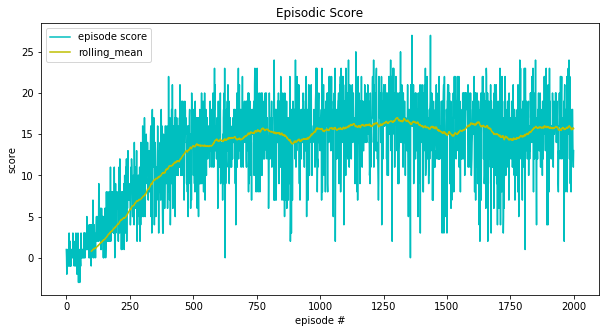

In [10]:
dqn_scores = train_dqn(agent=agent_dqn, memory=agent_dqn.memory,
                       n_episodes=2000, pth='./checkpoint/agent_dqn_checkpoint.pth')

np.save('./data/dqn_scores.npy', dqn_scores)

plot_scores(dqn_scores)

In [9]:
from agent_ddqn import Agent
agent_ddqn = Agent(state_size=37, action_size=4, seed=25)

Episode   100	Average Score:      0.42	Memory Size: 30000	Loss:0.00000000
Episode   200	Average Score:      3.90	Memory Size: 60000	Loss:0.00000000
Episode   300	Average Score:      6.72	Memory Size: 90000	Loss:0.00000000
Episode   400	Average Score:     10.07	Memory Size:100000	Loss:0.00000000
Episode   500	Average Score:     13.45	Memory Size:100000	Loss:0.00000000
Episode   600	Average Score:     15.40	Memory Size:100000	Loss:0.00000000
Episode   700	Average Score:     15.58	Memory Size:100000	Loss:0.00000000
Episode   800	Average Score:     16.20	Memory Size:100000	Loss:0.00000000
Episode   900	Average Score:     16.10	Memory Size:100000	Loss:0.00000000
Episode  1000	Average Score:     15.64	Memory Size:100000	Loss:0.00000000
Episode  1100	Average Score:     15.92	Memory Size:100000	Loss:0.00000000
Episode  1200	Average Score:     15.56	Memory Size:100000	Loss:0.00000000
Episode  1300	Average Score:     15.80	Memory Size:100000	Loss:0.00000000
Episode  1400	Average Score:     16.20

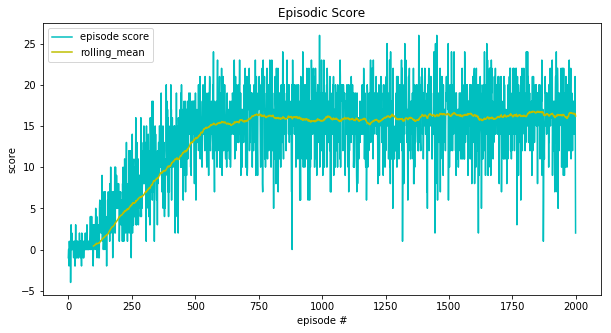

In [12]:
ddqn_scores = train_dqn(agent=agent_ddqn, memory=agent_ddqn.memory,
                        n_episodes=2000, pth='./checkpoint/agent_ddqn_checkpoint.pth')

np.save('./data/ddqn_scores.npy', ddqn_scores)

plot_scores(ddqn_scores)

In [8]:
from prioritizedagent import PrioritizedAgent

agent_p_ddqn = PrioritizedAgent(state_size=37, action_size=4, seed=25, is_double_q=True)

Episode   100	Average Score:      1.66	Memory Size:100000	Loss:0.00549157
Episode   200	Average Score:      6.05	Memory Size:100000	Loss:0.00556755
Episode   300	Average Score:      9.09	Memory Size:100000	Loss:0.00549427
Episode   400	Average Score:     12.28	Memory Size:100000	Loss:0.00519090
Episode   500	Average Score:     13.95	Memory Size:100000	Loss:0.00551714
Episode   600	Average Score:     15.22	Memory Size:100000	Loss:0.00566347
Episode   700	Average Score:     16.07	Memory Size:100000	Loss:0.00596770
Episode   800	Average Score:     16.76	Memory Size:100000	Loss:0.00611725
Episode   900	Average Score:     16.32	Memory Size:100000	Loss:0.00614940
Episode  1000	Average Score:     17.45	Memory Size:100000	Loss:0.00629795
Episode  1100	Average Score:     16.54	Memory Size:100000	Loss:0.00633932
Episode  1200	Average Score:     16.98	Memory Size:100000	Loss:0.00641483
Episode  1300	Average Score:     17.15	Memory Size:100000	Loss:0.00635808
Episode  1400	Average Score:     17.19

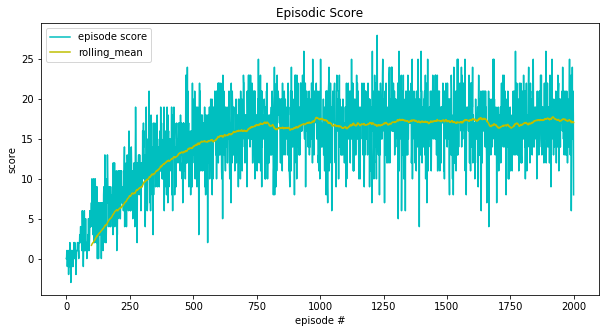

In [10]:

p_ddqn_scores = train_dqn(agent=agent_p_ddqn, memory=agent_p_ddqn.prioritized_memory,
                          n_episodes=2000, pth='./checkpoint/agent_p_ddqn_checkpoint.pth')

np.save('./data/p_ddqn_scores.npy', p_ddqn_scores)

plot_scores(p_ddqn_scores)